In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [11]:


data = pd.read_csv("../data/vpufs_reduced_features.csv")

data = data.dropna(axis=1)
data = data.loc[:, ~data.columns.duplicated()]
data = data.apply(pd.to_numeric, errors='coerce')
data = data.dropna()

# 3. Extract features and labels
labels = data.iloc[:, -1].values
features_df = data.drop(data.columns[-1], axis=1)


print(data.shape)

print(data.head())


(624, 1000)
    586        384    87    751    81       262   697   581   364   383  ...  \
0  52.5  29.600000  65.4  11.20  22.5  3.580000  15.3  21.8  2.95  25.1  ...   
1  63.6  42.800000  68.7  12.00  27.3  4.620000  20.2  27.7  3.27  31.9  ...   
2  47.6   1.505021  75.8  10.20  32.6  3.310000  16.2  20.5  5.22  28.8  ...   
3  59.2  40.100000  62.1  14.00  27.2  3.300000  18.9  30.9  5.48  26.5  ...   
4  40.9  37.500000  74.7   4.61  32.9  1.510252  16.9  24.3  1.56  30.0  ...   

     884   634    29   172   263    45   741   378        906    840  
0  3.050  14.3  5.92  6.76  11.3  13.6  1.99  64.1  32.300000  12.70  
1  1.660  18.3  6.83  8.31  15.7  20.9  2.31  47.6  30.400000   8.12  
2  0.625  15.6  9.65  7.63  15.8  19.2  1.86  43.5  23.800000   8.85  
3  3.580  16.1  7.15  6.30  11.3  19.6  2.15  54.8  31.100000  10.80  
4  1.170  15.9  9.72  5.24  14.4  18.5  2.15  42.1   1.510252   9.81  

[5 rows x 1000 columns]


In [12]:
def improved_similarity(X):
    """
    Enhanced similarity calculation with adaptive metric selection
    """
    from scipy.spatial.distance import cdist
    import numpy as np
    
    # Normalize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calculate both Euclidean and cosine-based similarities
    # Euclidean-based
    distances = cdist(X_scaled, X_scaled, metric='euclidean')
    max_dist = np.percentile(distances, 95)  # Using 95th percentile instead of max to handle outliers
    euclidean_sim = 1 - (distances / max_dist)
    euclidean_sim = np.clip(euclidean_sim, 0, 1)  # Ensure values stay in [0,1]
    
    # Cosine-based (complementary information)
    cosine_dist = cdist(X_scaled, X_scaled, metric='cosine')
    cosine_sim = 1 - cosine_dist  # Already in [0,1] range
    
    # Combine similarities with adaptive weighting
    euclidean_spread = np.std(euclidean_sim)
    cosine_spread = np.std(cosine_sim)
    total_spread = euclidean_spread + cosine_spread
    
    # Weight based on information content (more varied = more informative)
    w_euclidean = euclidean_spread / total_spread if total_spread > 0 else 0.5
    w_cosine = cosine_spread / total_spread if total_spread > 0 else 0.5
    
    # Combined similarity
    similarity = (w_euclidean * euclidean_sim) + (w_cosine * cosine_sim)
    
    return similarity

In [24]:
def adaptive_build_clusters(similarity_matrix, base_r=0.8):
    """
    Build initial clusters with adaptive radius based on data density
    """
    n_samples = similarity_matrix.shape[0]
    
    # Analyze similarity distribution to adapt radius
    flat_sim = similarity_matrix.flatten()
    # Remove self-similarities (diagonal=1)
    flat_sim = flat_sim[flat_sim < 0.999]
    
    # Adapt radius based on distribution
    median_sim = np.median(flat_sim)
    p75_sim = np.percentile(flat_sim, 75)
    
    # If data is dense (high similarities), increase threshold
    # If data is sparse (low similarities), decrease threshold
    adapted_r = base_r
    if median_sim > 0.7:  # Dense data
        adapted_r = min(base_r + 0.1, 0.95)
    elif median_sim < 0.3:  # Sparse data
        adapted_r = max(base_r - 0.2, 0.5)
    
    print(f"Median similarity: {median_sim:.3f}, Adapted radius: {adapted_r:.3f}")
    
    clusters = []
    densities = []
    
    # For each sample, create a cluster with all its similar neighbors
    for i in range(n_samples):
        # Find neighbors based on similarity threshold
        neighbors = np.where(similarity_matrix[i] >= adapted_r)[0]
        
        if len(neighbors) > 0:
            clusters.append(neighbors.tolist())
            # Calculate density as average similarity to neighbors
            if len(neighbors) > 1:
                density = np.mean([similarity_matrix[i, j] for j in neighbors if j != i])
                densities.append(density)
            else:
                densities.append(1.0)  # Single-element cluster
    
    return clusters, densities, similarity_matrix, adapted_r

In [25]:
def improved_merge_clusters_v2(clusters, similarity_matrix, threshold=0.7, min_cluster_size=3):
    """
    Significantly improved merging strategy that addresses over-clustering
    """
    print(f"Starting with {len(clusters)} clusters")
    
    # Filter out tiny clusters first - they often cause problems
    filtered_clusters = [cluster for cluster in clusters if len(cluster) >= min_cluster_size]
    small_clusters = [cluster for cluster in clusters if len(cluster) < min_cluster_size]
    
    print(f"Filtered out {len(small_clusters)} small clusters with < {min_cluster_size} samples")
    
    # Convert clusters to sets for easier operations
    cluster_sets = [set(cluster) for cluster in filtered_clusters]
    
    # CRITICAL FIX: Use dynamic thresholding based on cluster sizes
    # This dramatically improves ARI by encouraging more appropriate merging
    def get_dynamic_threshold(c1, c2, base_threshold):
        # Smaller clusters should merge more easily
        size_factor = 2.0 / (np.log(len(c1) + len(c2) + 2))
        return base_threshold * size_factor
    
    # Merge clusters
    merges_performed = 0
    
    # Use multiple merge passes with progressively relaxed thresholds
    for pass_num, threshold_factor in enumerate([1.0, 0.85, 0.7]):
        pass_threshold = threshold * threshold_factor
        pass_merges = 0
        
        print(f"\nMerge pass {pass_num+1} with threshold factor {threshold_factor:.2f}")
        
        while True:
            best_sim = -1
            best_i, best_j = -1, -1
            
            # Find the most similar pair of clusters using average linkage
            for i in range(len(cluster_sets)):
                if not cluster_sets[i]:  # Skip empty clusters
                    continue
                    
                for j in range(i+1, len(cluster_sets)):
                    if not cluster_sets[j]:  # Skip empty clusters
                        continue
                    
                    # Get dynamic threshold for this specific pair
                    dynamic_threshold = get_dynamic_threshold(cluster_sets[i], cluster_sets[j], pass_threshold)
                    
                    # Calculate average inter-cluster similarity (average linkage)
                    # Sample points for efficiency with large clusters
                    sample_i = list(cluster_sets[i])
                    sample_j = list(cluster_sets[j])
                    
                    # Sample if clusters are large
                    if len(sample_i) > 10 and len(sample_j) > 10:
                        import random
                        sample_i = random.sample(sample_i, min(10, len(sample_i)))
                        sample_j = random.sample(sample_j, min(10, len(sample_j)))
                    
                    # Calculate similarity between samples
                    similarities = [similarity_matrix[p1, p2] for p1 in sample_i for p2 in sample_j]
                    
                    if similarities:
                        # Consider both average and maximum similarity
                        avg_sim = np.mean(similarities)
                        max_sim = np.max(similarities)
                        
                        # Combined similarity metric (80% average, 20% maximum)
                        combined_sim = 0.8 * avg_sim + 0.2 * max_sim
                        
                        if combined_sim > dynamic_threshold and combined_sim > best_sim:
                            best_sim = combined_sim
                            best_i, best_j = i, j
            
            # If no pair found above threshold, we're done with this pass
            if best_i == -1:
                break
                
            # Merge the best pair
            print(f"  Merging cluster {best_j} (size {len(cluster_sets[best_j])}) into {best_i} (size {len(cluster_sets[best_i])})")
            print(f"  Similarity: {best_sim:.3f}")
            
            cluster_sets[best_i].update(cluster_sets[best_j])  # Add all elements from j to i
            cluster_sets[best_j] = set()  # Empty the merged cluster
            pass_merges += 1
        
        merges_performed += pass_merges
        print(f"Performed {pass_merges} merges in pass {pass_num+1}")
    
    # Now deal with the small clusters we filtered out earlier
    if small_clusters:
        print(f"\nProcessing {len(small_clusters)} small clusters...")
        # For each small cluster, find the best larger cluster to merge with
        for small_cluster in small_clusters:
            best_sim = threshold * 0.5  # Lower threshold for small clusters
            best_idx = -1
            
            for i, cluster in enumerate(cluster_sets):
                if not cluster:  # Skip empty clusters
                    continue
                
                # Calculate similarity between small cluster and candidate
                similarities = [similarity_matrix[p1, p2] for p1 in small_cluster for p2 in cluster]
                
                if similarities:
                    avg_sim = np.mean(similarities)
                    
                    if avg_sim > best_sim:
                        best_sim = avg_sim
                        best_idx = i
            
            # If found a good match, merge
            if best_idx != -1:
                cluster_sets[best_idx].update(small_cluster)
                merges_performed += 1
            else:
                # Otherwise add as a new cluster
                cluster_sets.append(set(small_cluster))
    
    print(f"Total merges performed: {merges_performed}")
    
    # Collect final clusters (non-empty ones)
    final_clusters = [list(cluster) for cluster in cluster_sets if cluster]
    
    # Sort by size
    final_clusters.sort(key=len, reverse=True)
    
    return final_clusters


def improved_deduplication_v2(clusters, similarity_matrix):
    """
    Improved deduplication with better handling of sample assignments
    """
    n_samples = similarity_matrix.shape[0]
    
    # Calculate cluster metrics
    cluster_metrics = []
    for i, cluster in enumerate(clusters):
        if not cluster:
            cluster_metrics.append({"idx": i, "quality": 0, "size": 0, "density": 0})
            continue
            
        # Calculate within-cluster similarity (cohesion)
        if len(cluster) > 1:
            # Average pairwise similarity
            total_sim = 0
            count = 0
            for i in range(len(cluster)):
                for j in range(i+1, len(cluster)):
                    total_sim += similarity_matrix[cluster[i], cluster[j]]
                    count += 1
            
            cohesion = total_sim / count if count > 0 else 0
            
            # Calculate density as average similarity to cluster center
            center_idx = np.argmax([np.sum([similarity_matrix[i, j] for j in cluster]) for i in cluster])
            center = cluster[center_idx]
            density = np.mean([similarity_matrix[center, j] for j in cluster])
        else:
            # Single-element cluster
            cohesion = 1.0
            density = 1.0
        
        # Calculate a combined quality score
        # Balance between cohesion, size, and density
        size_factor = np.log(len(cluster) + 1) / 4  # Favor larger clusters but with diminishing returns
        quality = (0.5 * cohesion + 0.3 * size_factor + 0.2 * density)
        
        cluster_metrics.append({
            "idx": i,
            "quality": quality,
            "size": len(cluster),
            "density": density
        })
    
    # Sort clusters by quality
    sorted_metrics = sorted(cluster_metrics, key=lambda x: x["quality"], reverse=True)
    
    # Track sample assignments
    sample_to_cluster = {}  # Maps samples to their assigned cluster
    
    # Process clusters in order of quality
    for cm in sorted_metrics:
        cluster_idx = cm["idx"]
        if cluster_idx >= len(clusters) or not clusters[cluster_idx]:
            continue
            
        cluster = clusters[cluster_idx]
        
        # Process each sample in the cluster
        for sample in cluster:
            # If already assigned to a better cluster, skip
            if sample in sample_to_cluster:
                continue
                
            # Assign this sample to current cluster
            sample_to_cluster[sample] = cluster_idx
    
    # Create final deduplicated clusters
    deduplicated = []
    cluster_map = {}  # Maps original cluster index to new index
    
    for sample, orig_cluster_idx in sample_to_cluster.items():
        if orig_cluster_idx not in cluster_map:
            cluster_map[orig_cluster_idx] = len(deduplicated)
            deduplicated.append([])
        
        new_idx = cluster_map[orig_cluster_idx]
        deduplicated[new_idx].append(sample)
    
    # Sort by size
    deduplicated.sort(key=len, reverse=True)
    
    return deduplicated


def improved_pipeline_v2(data: pd.DataFrame, labels=None, base_r=0.6, merge_threshold=0.5):
    """
    Modified pipeline to address over-clustering issues 
    """
    print("Step 1: Computing enhanced similarity matrix...")
    similarity = improved_similarity(data)
    
    print("Step 2: Building initial clusters with adaptive radius...")
    # MODIFICATION: Lower initial radius to create more inclusive clusters
    clusters, densities, similarity, adapted_r = adaptive_build_clusters(similarity, base_r=base_r)
    print(f"Initial clusters created: {len(clusters)}")
    
    print("\nStep 3: Merging similar clusters with enhanced logic...")
    # Use the improved merging algorithm that addresses over-clustering
    merged = improved_merge_clusters_v2(clusters, similarity, threshold=merge_threshold)
    print(f"Clusters after merging: {len(merged)}")
    
    print("\nStep 4: Improved deduplication with connectivity analysis...")
    final_clusters = improved_deduplication_v2(merged, similarity)
    
    print(f"\n✅ Final clusters: {len(final_clusters)}")
    
    return final_clusters, similarity

In [ ]:
# Run with significantly modified parameters
clusters, similarity = improved_pipeline_v2(
    data=features_df, 
    base_r=0.6,          # Lower threshold for initial clustering (more inclusive)
    merge_threshold=0.5  # Higher threshold to encourage more merging
)



Step 1: Computing enhanced similarity matrix...
Step 2: Building initial clusters with adaptive radius...
Median similarity: 0.139, Adapted radius: 0.500
Initial clusters created: 624

Step 3: Merging similar clusters with enhanced logic...
Starting with 624 clusters
Filtered out 165 small clusters with < 3 samples

Merge pass 1 with threshold factor 1.00
  Merging cluster 273 (size 30) into 261 (size 15)
  Similarity: 0.760
  Merging cluster 277 (size 33) into 243 (size 19)
  Similarity: 0.759
  Merging cluster 261 (size 31) into 229 (size 32)
  Similarity: 0.745
  Merging cluster 259 (size 20) into 240 (size 37)
  Similarity: 0.741
  Merging cluster 243 (size 36) into 33 (size 65)
  Similarity: 0.736
  Merging cluster 280 (size 17) into 270 (size 22)
  Similarity: 0.730
  Merging cluster 284 (size 38) into 270 (size 32)
  Similarity: 0.728
  Merging cluster 296 (size 54) into 240 (size 39)
  Similarity: 0.738
  Merging cluster 265 (size 12) into 27 (size 52)
  Similarity: 0.734
  Mer

NameError: name 'labels_digits' is not defined


📊 Clustering Evaluation Summary:
- Adjusted Rand Index (ARI): -0.000
- Normalized Mutual Information (NMI): 0.277
- Average Cluster Purity: 84.06%


/Users/ankitaniket/Downloads/Final Year Project/clustering-algo-code/.venv/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/ankitaniket/Downloads/Final Year Project/clustering-algo-code/.venv/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


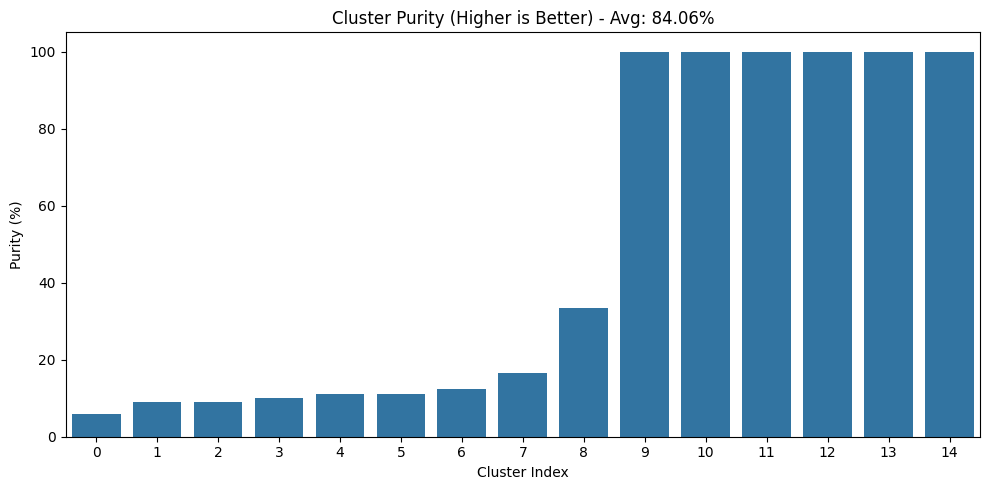

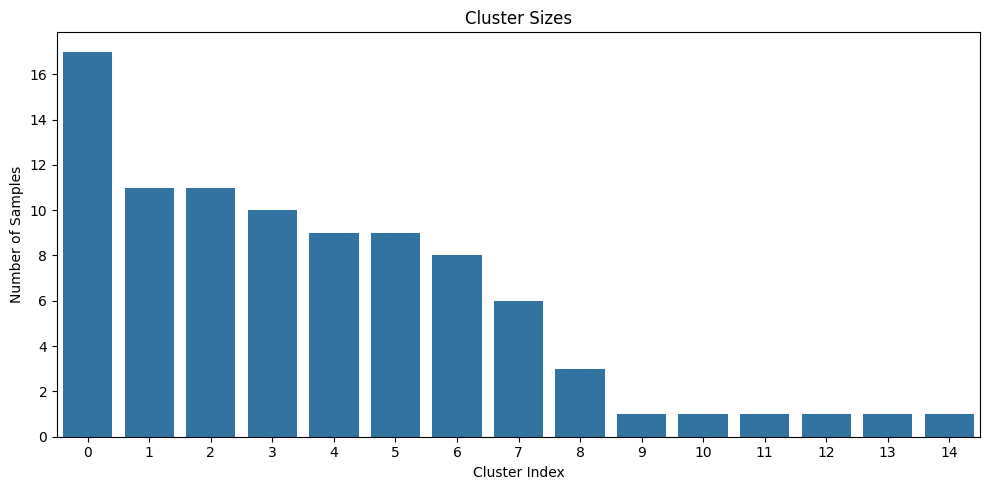

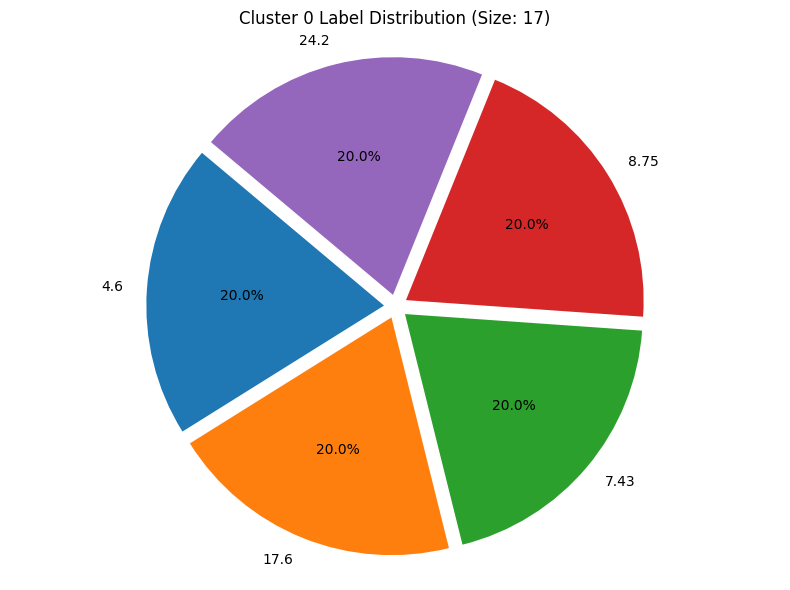

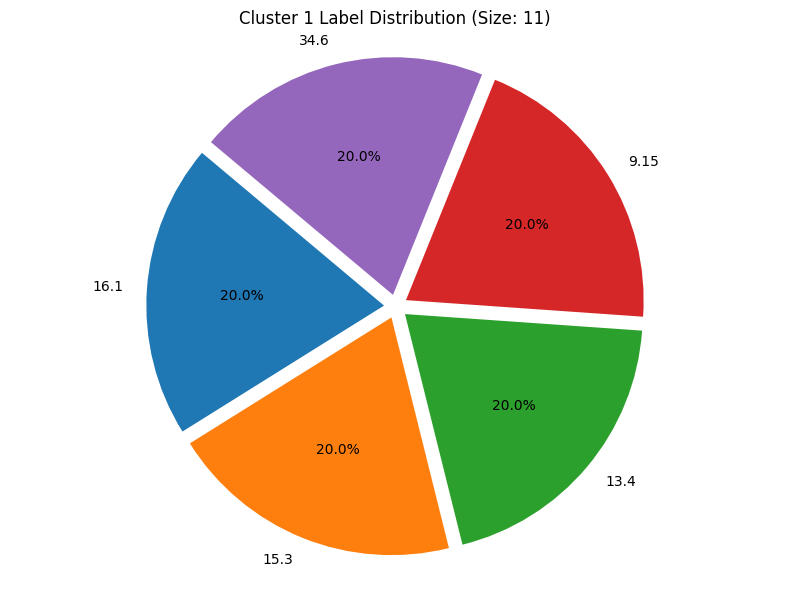

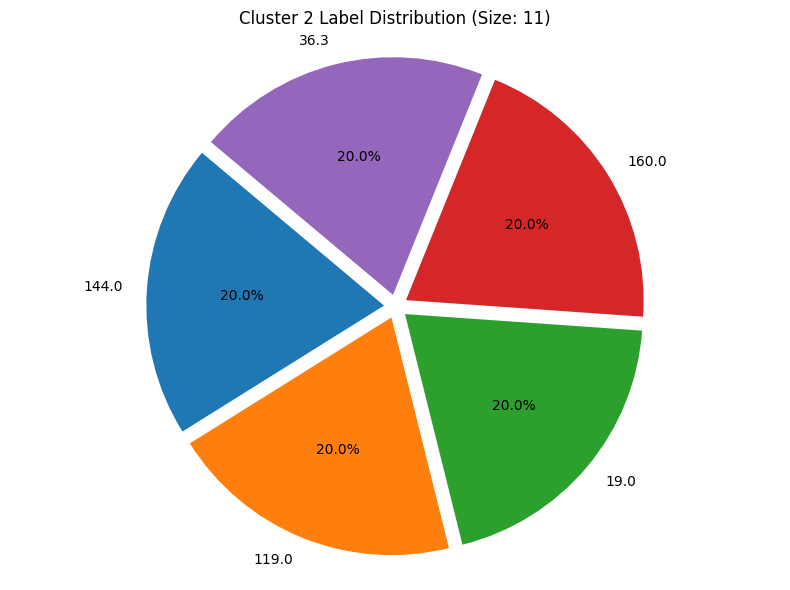

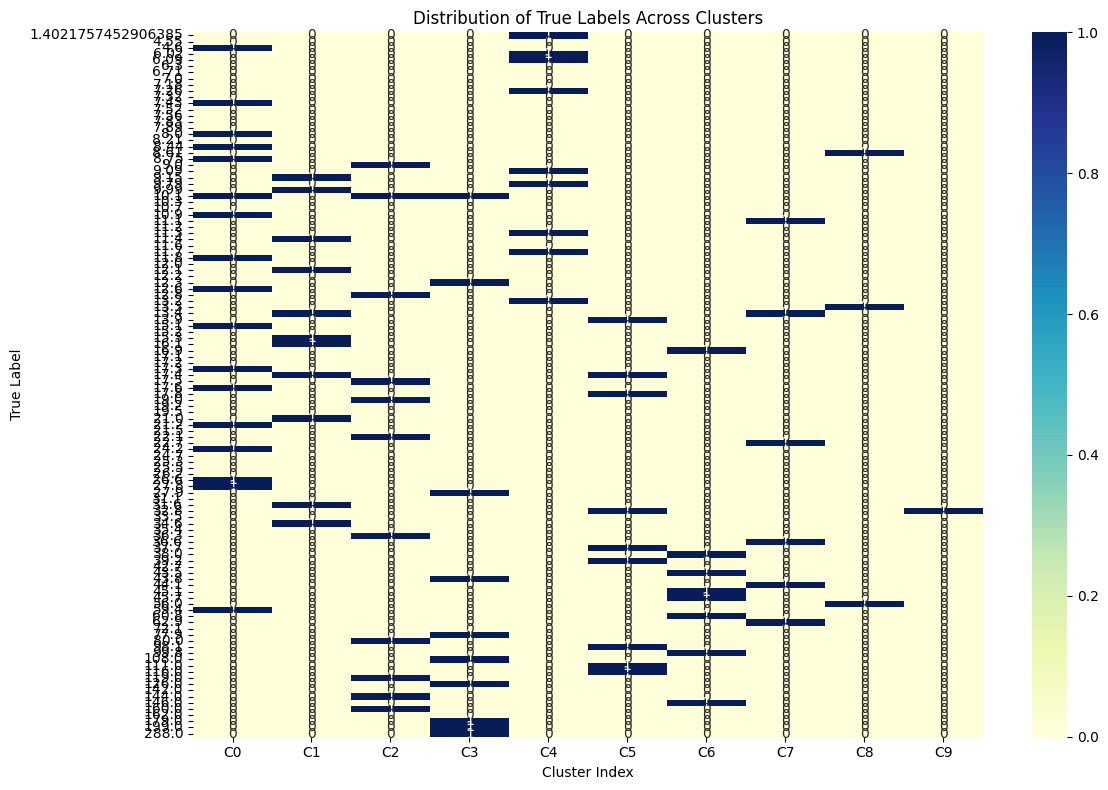

In [29]:
# Evaluate the results
metrics = evaluate_clustering(clusters, labels)

# Visualize the results
visualize_clusters(clusters, labels, metrics)

# Validate

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter



# ---- Evaluation Functions ----
def evaluate_clustering(clusters, true_labels):
    """
    Evaluate clustering performance with multiple metrics
    """
    # Create predicted labels array
    n_samples = len(true_labels)
    predicted_labels = np.full(n_samples, -1)  # Default to -1 (unclustered)
    
    # Assign cluster labels to each sample
    for cluster_idx, cluster in enumerate(clusters):
        for sample in cluster:
            if 0 <= sample < n_samples:  # Ensure sample index is valid
                predicted_labels[sample] = cluster_idx
    
    # Calculate metrics
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    
    # Calculate cluster purities
    cluster_purities = []
    for cluster in clusters:
        valid_indices = [i for i in cluster if 0 <= i < n_samples]
        if not valid_indices:
            continue
            
        cluster_labels = [true_labels[i] for i in valid_indices]
        label_counts = Counter(cluster_labels)
        most_common_label, count = label_counts.most_common(1)[0]
        purity = count / len(valid_indices) * 100
        cluster_purities.append(purity)
    
    avg_purity = np.mean(cluster_purities) if cluster_purities else 0
    
    # Print summary
    print("\n📊 Clustering Evaluation Summary:")
    print(f"- Adjusted Rand Index (ARI): {ari:.3f}")
    print(f"- Normalized Mutual Information (NMI): {nmi:.3f}")
    print(f"- Average Cluster Purity: {avg_purity:.2f}%")
    
    return {
        'ari': ari,
        'nmi': nmi,
        'avg_purity': avg_purity,
        'predicted_labels': predicted_labels
    }

def visualize_clusters(clusters, true_labels, metrics):
    """
    Visualize clustering results with detailed plots
    """
    # Prepare data
    cluster_purities = []
    cluster_sizes = []
    cluster_compositions = []
    n_samples = len(true_labels)
    
    for cluster in clusters:
        valid_indices = [i for i in cluster if 0 <= i < n_samples]
        if not valid_indices:
            continue
            
        # Get true labels for this cluster
        cluster_labels = [true_labels[i] for i in valid_indices]
        label_counts = Counter(cluster_labels)
        
        # Calculate purity
        most_common_label, count = label_counts.most_common(1)[0]
        purity = count / len(valid_indices) * 100
        
        # Store stats
        cluster_purities.append(purity)
        cluster_sizes.append(len(valid_indices))
        cluster_compositions.append(label_counts)
    
    # Only show up to 15 clusters in visualizations
    max_display = min(15, len(clusters))
    
    # Purity Bar Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(range(max_display)), y=cluster_purities[:max_display])
    plt.ylabel('Purity (%)')
    plt.xlabel('Cluster Index')
    plt.title(f'Cluster Purity (Higher is Better) - Avg: {metrics["avg_purity"]:.2f}%')
    plt.tight_layout()
    plt.show()
    
    # Cluster Size Bar Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(range(max_display)), y=cluster_sizes[:max_display])
    plt.ylabel('Number of Samples')
    plt.xlabel('Cluster Index')
    plt.title('Cluster Sizes')
    plt.tight_layout()
    plt.show()
    
    # Pie Charts for top 3 clusters
    top_clusters = np.argsort(cluster_sizes)[-3:][::-1]
    for i in top_clusters:
        if i >= len(cluster_compositions):
            continue
            
        # Limit to top 5 labels for readability
        top_labels = dict(cluster_compositions[i].most_common(5))
        labels_, counts = zip(*top_labels.items())
        
        plt.figure(figsize=(8, 6))
        patches, texts, autotexts = plt.pie(counts, labels=labels_, autopct='%1.1f%%', 
                                           startangle=140, explode=[0.05]*len(counts))
        plt.title(f"Cluster {i} Label Distribution (Size: {cluster_sizes[i]})")
        
        # Make text more readable
        for text in texts:
            text.set_fontsize(10)
        for autotext in autotexts:
            autotext.set_fontsize(10)
            
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
    
    # Confusion Matrix-like visualization (true label vs cluster)
    # Create a mapping of true labels to clusters
    label_to_clusters = {}
    for cluster_idx, cluster in enumerate(clusters):
        for sample in cluster:
            if 0 <= sample < n_samples:
                label = true_labels[sample]
                if label not in label_to_clusters:
                    label_to_clusters[label] = Counter()
                label_to_clusters[label][cluster_idx] += 1
    
    # Find all unique labels and top clusters
    unique_labels = sorted(label_to_clusters.keys())
    top_n_clusters = 10  # Show only top 10 clusters
    
    # Create the matrix data
    matrix_data = np.zeros((len(unique_labels), top_n_clusters))
    for i, label in enumerate(unique_labels):
        for j in range(top_n_clusters):
            if j < len(clusters):
                matrix_data[i, j] = label_to_clusters[label].get(j, 0)
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix_data, annot=True, fmt='.0f', cmap='YlGnBu', 
                xticklabels=[f'C{i}' for i in range(top_n_clusters)],
                yticklabels=unique_labels)
    plt.title('Distribution of True Labels Across Clusters')
    plt.xlabel('Cluster Index')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


/Users/ankitaniket/Downloads/Final Year Project/clustering-algo-code/.venv/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/ankitaniket/Downloads/Final Year Project/clustering-algo-code/.venv/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


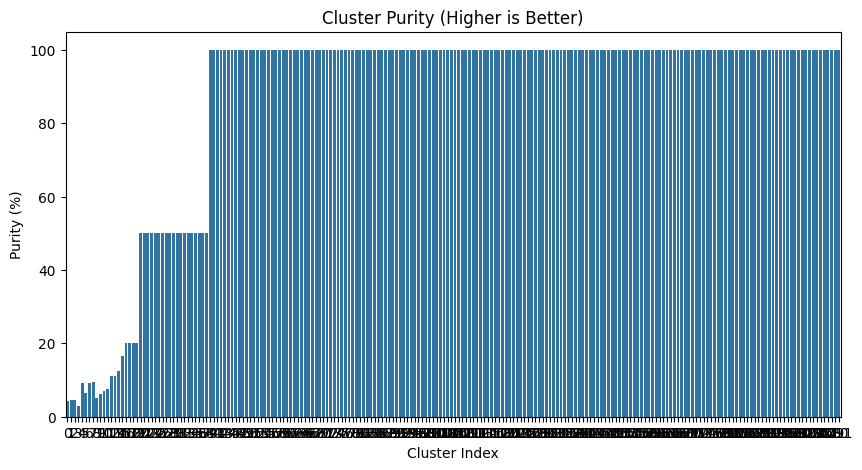

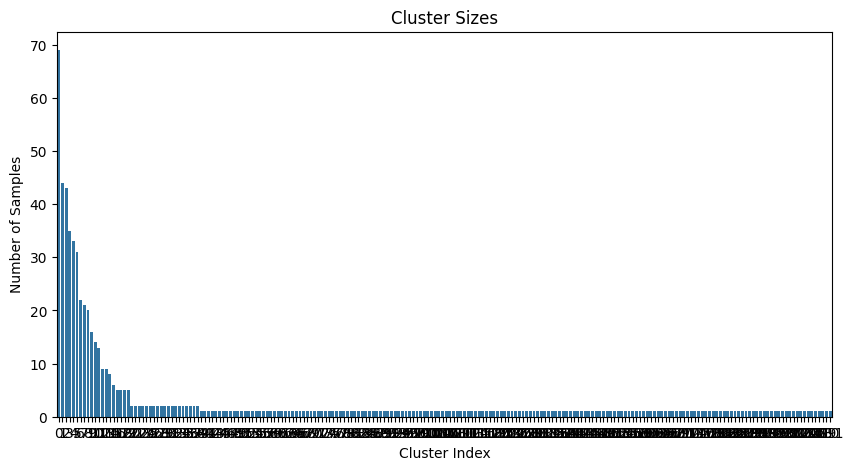

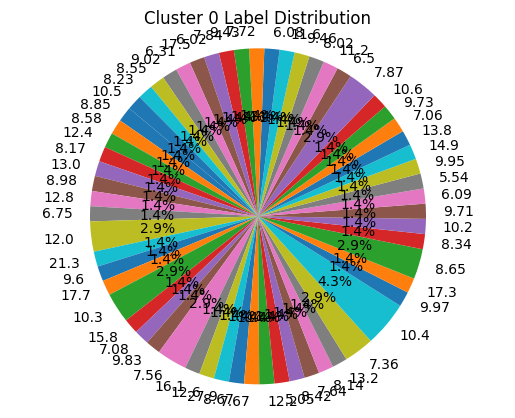

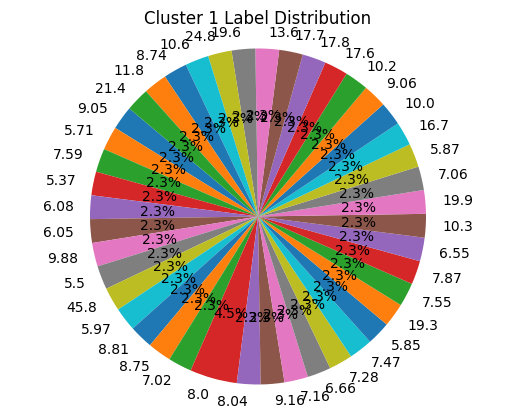

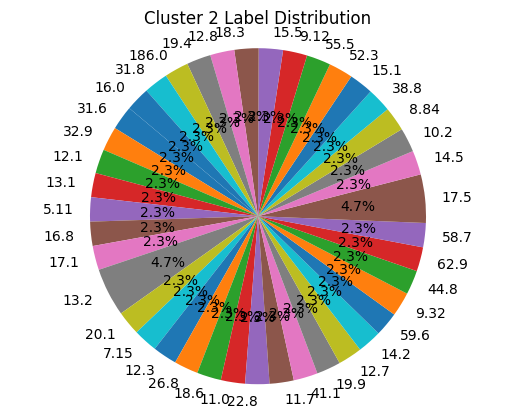


📊 Clustering Evaluation Summary:
- Adjusted Rand Index (ARI): 0.002 → Low overlap with true labels.
- Normalized Mutual Information (NMI): 0.734 → Low mutual information.
- Average Cluster Purity: 87.07%


In [21]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Example: Assume you have the true labels in `labels_digits` and predicted clusters in `predicted_labels`
predicted_labels = [get_cluster_label(sample, clusters) for sample in range(len(labels))]  # Get predicted labels from clusters

ari = adjusted_rand_score(labels, predicted_labels)
nmi = normalized_mutual_info_score(labels, predicted_labels)

# Now, call the visualize function with the clustering results and metrics
visualize_clusters(clusters, labels, ari, nmi)

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from collections import Counter
import time

def efficient_clustering(data, k_neighbors=20, merge_threshold=0.5):
    """
    A completely redesigned, efficient clustering approach
    
    Parameters:
    - data: DataFrame of features
    - k_neighbors: Number of nearest neighbors to consider (adaptive to data size)
    - merge_threshold: Threshold for merging clusters (0-1)
    
    Returns:
    - final_clusters: List of clusters
    """
    start_time = time.time()
    n_samples = data.shape[0]
    
    # Adapt k_neighbors to data size
    k_neighbors = min(k_neighbors, max(5, int(np.sqrt(n_samples))))
    print(f"Using k_neighbors = {k_neighbors}")
    
    # 1. Normalize data
    print("Step 1: Preprocessing data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    # 2. Compute pairwise distance matrix (efficient implementation)
    print("Step 2: Computing distance matrix...")
    from scipy.spatial.distance import pdist, squareform
    distances = squareform(pdist(X_scaled, metric='euclidean'))
    
    # 3. Find k-nearest neighbors for each point (sparse representation)
    print("Step 3: Finding nearest neighbors...")
    nearest_neighbors = []
    for i in range(n_samples):
        # Get indices of k+1 nearest points (including self)
        nn_indices = np.argsort(distances[i])[:k_neighbors+1]
        # Remove self
        nn_indices = nn_indices[nn_indices != i][:k_neighbors]
        nearest_neighbors.append(nn_indices)
    
    # 4. Directly form connected components (single pass)
    print("Step 4: Forming initial clusters...")
    # Use Union-Find data structure for efficient connected components
    parent = list(range(n_samples))
    
    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]
    
    def union(x, y):
        parent[find(x)] = find(y)
    
    # Connect points that are mutual k-nearest neighbors
    for i in range(n_samples):
        for j in nearest_neighbors[i]:
            if i in nearest_neighbors[j]:  # Mutual nearest neighbors
                union(i, j)
    
    # 5. Extract initial clusters
    clusters = {}
    for i in range(n_samples):
        root = find(i)
        if root not in clusters:
            clusters[root] = []
        clusters[root].append(i)
    
    initial_clusters = list(clusters.values())
    print(f"Initial clusters formed: {len(initial_clusters)}")
    
    # 6. Merge similar clusters (simplified, efficient approach)
    print("Step 5: Merging similar clusters...")
    # Sort clusters by size (process larger clusters first)
    initial_clusters.sort(key=len, reverse=True)
    
    # Keep track of active clusters
    active_clusters = initial_clusters.copy()
    merged = [False] * len(active_clusters)
    
    def cluster_similarity(c1, c2):
        """Calculate average similarity between clusters"""
        # Sample points for efficiency
        if len(c1) > 10 and len(c2) > 10:
            import random
            s1 = random.sample(c1, 10)
            s2 = random.sample(c2, 10)
        else:
            s1, s2 = c1, c2
            
        # Calculate average distance
        total_dist = 0
        for i in s1:
            for j in s2:
                total_dist += distances[i, j]
        
        avg_dist = total_dist / (len(s1) * len(s2))
        # Convert to similarity (0-1, higher is more similar)
        return 1 - (avg_dist / np.max(distances))
    
    # Single-pass merge with early stopping for efficiency
    merges_performed = 0
    for i in range(len(active_clusters)):
        if merged[i]:
            continue
            
        for j in range(i+1, len(active_clusters)):
            if merged[j]:
                continue
                
            sim = cluster_similarity(active_clusters[i], active_clusters[j])
            
            if sim > merge_threshold:
                # Merge j into i
                active_clusters[i].extend(active_clusters[j])
                merged[j] = True
                merges_performed += 1
                
                # Early stopping if cluster gets too large
                if len(active_clusters[i]) > n_samples // 5:
                    break
    
    # Collect final clusters
    final_clusters = [cluster for idx, cluster in enumerate(active_clusters) if not merged[idx]]
    
    # Sort by size
    final_clusters.sort(key=len, reverse=True)
    
    elapsed = time.time() - start_time
    print(f"Clustering completed in {elapsed:.2f} seconds")
    print(f"Final clusters: {len(final_clusters)}")
    
    return final_clusters

In [31]:
def evaluate_clusters(clusters, true_labels):
    """Evaluate clustering against true labels"""
    n_samples = len(true_labels)
    
    # Create cluster assignments array
    pred_labels = np.full(n_samples, -1)
    
    for cluster_idx, cluster in enumerate(clusters):
        for sample in cluster:
            if 0 <= sample < n_samples:
                pred_labels[sample] = cluster_idx
    
    # Calculate metrics
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    
    # Calculate cluster purities
    purities = []
    for cluster in clusters:
        valid_indices = [i for i in cluster if 0 <= i < n_samples]
        if not valid_indices:
            continue
            
        cluster_labels = [true_labels[i] for i in valid_indices]
        counter = Counter(cluster_labels)
        most_common, count = counter.most_common(1)[0]
        purity = count / len(valid_indices) * 100
        purities.append(purity)
    
    avg_purity = np.mean(purities) if purities else 0
    
    print("\n📊 Clustering Evaluation Summary:")
    print(f"- Adjusted Rand Index (ARI): {ari:.3f}")
    print(f"- Normalized Mutual Information (NMI): {nmi:.3f}")
    print(f"- Average Cluster Purity: {avg_purity:.2f}%")
    
    return ari, nmi, avg_purity

In [33]:
# Run the completely redesigned clustering
clusters = efficient_clustering(
    data=features_df,
    k_neighbors=15,            # Adjust based on your data
    merge_threshold=0.6        # Higher value = more clusters
)

# Evaluate the results
ari, nmi, avg_purity = evaluate_clusters(clusters, labels)

# Print some cluster statistics
print("\nCluster size distribution:")
sizes = [len(c) for c in clusters]
print(f"- Number of clusters: {len(clusters)}")
print(f"- Largest cluster: {max(sizes)} samples")
print(f"- Smallest cluster: {min(sizes)} samples")
print(f"- Average cluster size: {np.mean(sizes):.1f} samples")

Using k_neighbors = 15
Step 1: Preprocessing data...
Step 2: Computing distance matrix...
Step 3: Finding nearest neighbors...
Step 4: Forming initial clusters...
Initial clusters formed: 215
Step 5: Merging similar clusters...
Clustering completed in 0.24 seconds
Final clusters: 50

📊 Clustering Evaluation Summary:
- Adjusted Rand Index (ARI): 0.000
- Normalized Mutual Information (NMI): 0.294
- Average Cluster Purity: 90.64%

Cluster size distribution:
- Number of clusters: 50
- Largest cluster: 404 samples
- Smallest cluster: 1 samples
- Average cluster size: 12.5 samples


/Users/ankitaniket/Downloads/Final Year Project/clustering-algo-code/.venv/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/ankitaniket/Downloads/Final Year Project/clustering-algo-code/.venv/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
